# ADVERSARIAL EXAMPLES VISUALIZATION - PHASE 4.3/4.4
===================================================

### Publication-quality visualization and analysis of adversarial examples on medical imaging data (ISIC 2018).


## Objectives:
-----------
1. Visualize clean vs adversarial images (FGSM, PGD, C&W)
2. Quantify perturbation characteristics (L∞, L2, SSIM)
3. Analyze model predictions and confidence changes
4. Class-wise vulnerability analysis
5. Transferability visualization (ResNet vs EfficientNet)

## Expected Outputs:
-----------------
- Figure 1: Clean vs Adversarial Grid (6×4 layout)
- Figure 2: Perturbation Heatmaps (amplified ×10)
- Figure 3: Prediction Confidence Changes
- Figure 4: Class-wise Attack Success Rates
- Figure 5: Transferability Patterns

### Author: Viraj Pankaj Jain
### Date: November 24, 2025

## SECTION 1: Setup and Imports 

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from PIL import Image

# Styling for publication-quality plots
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Project imports
PROJECT_ROOT = Path.cwd().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

from src.attacks.fgsm import FGSM, FGSMConfig
from src.attacks.pgd import PGD, PGDConfig
from src.models.build import build_model
from src.datasets.isic import ISICDataset
from src.datasets.transforms import get_test_transforms

print("✅ Imports successful")

ModuleNotFoundError: No module named 'src'

## SECTION 2: Load Models and Data

In [2]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Load ResNet-50 baseline (seed 42)
resnet_checkpoint = PROJECT_ROOT / "checkpoints" / "baseline" / "seed_42" / "best.pt"
resnet_model = build_model("resnet50", num_classes=7, pretrained=False)
resnet_model.load_state_dict(torch.load(resnet_checkpoint)["model_state_dict"])
resnet_model.to(device)
resnet_model.eval()
print("✅ ResNet-50 loaded")

# Load test data
data_root = PROJECT_ROOT / "data" / "processed" / "isic2018"
test_dataset = ISICDataset(
    root=str(data_root),
    split="test",
    csv_path=str(data_root / "metadata_processed.csv"),
    transforms=get_test_transforms("isic", 224),
)

# Get class names
class_names = [
    "Melanoma", "Melanocytic nevus", "Basal cell carcinoma",
    "Actinic keratosis", "Benign keratosis", "Dermatofibroma", "Vascular lesion"
]

print(f"✅ Dataset loaded: {len(test_dataset)} samples")


Device: cuda


NameError: name 'build_model' is not defined

## SECTION 4: Visualization - Clean vs Adversarial Grid

NameError: name 'all_adversarials' is not defined

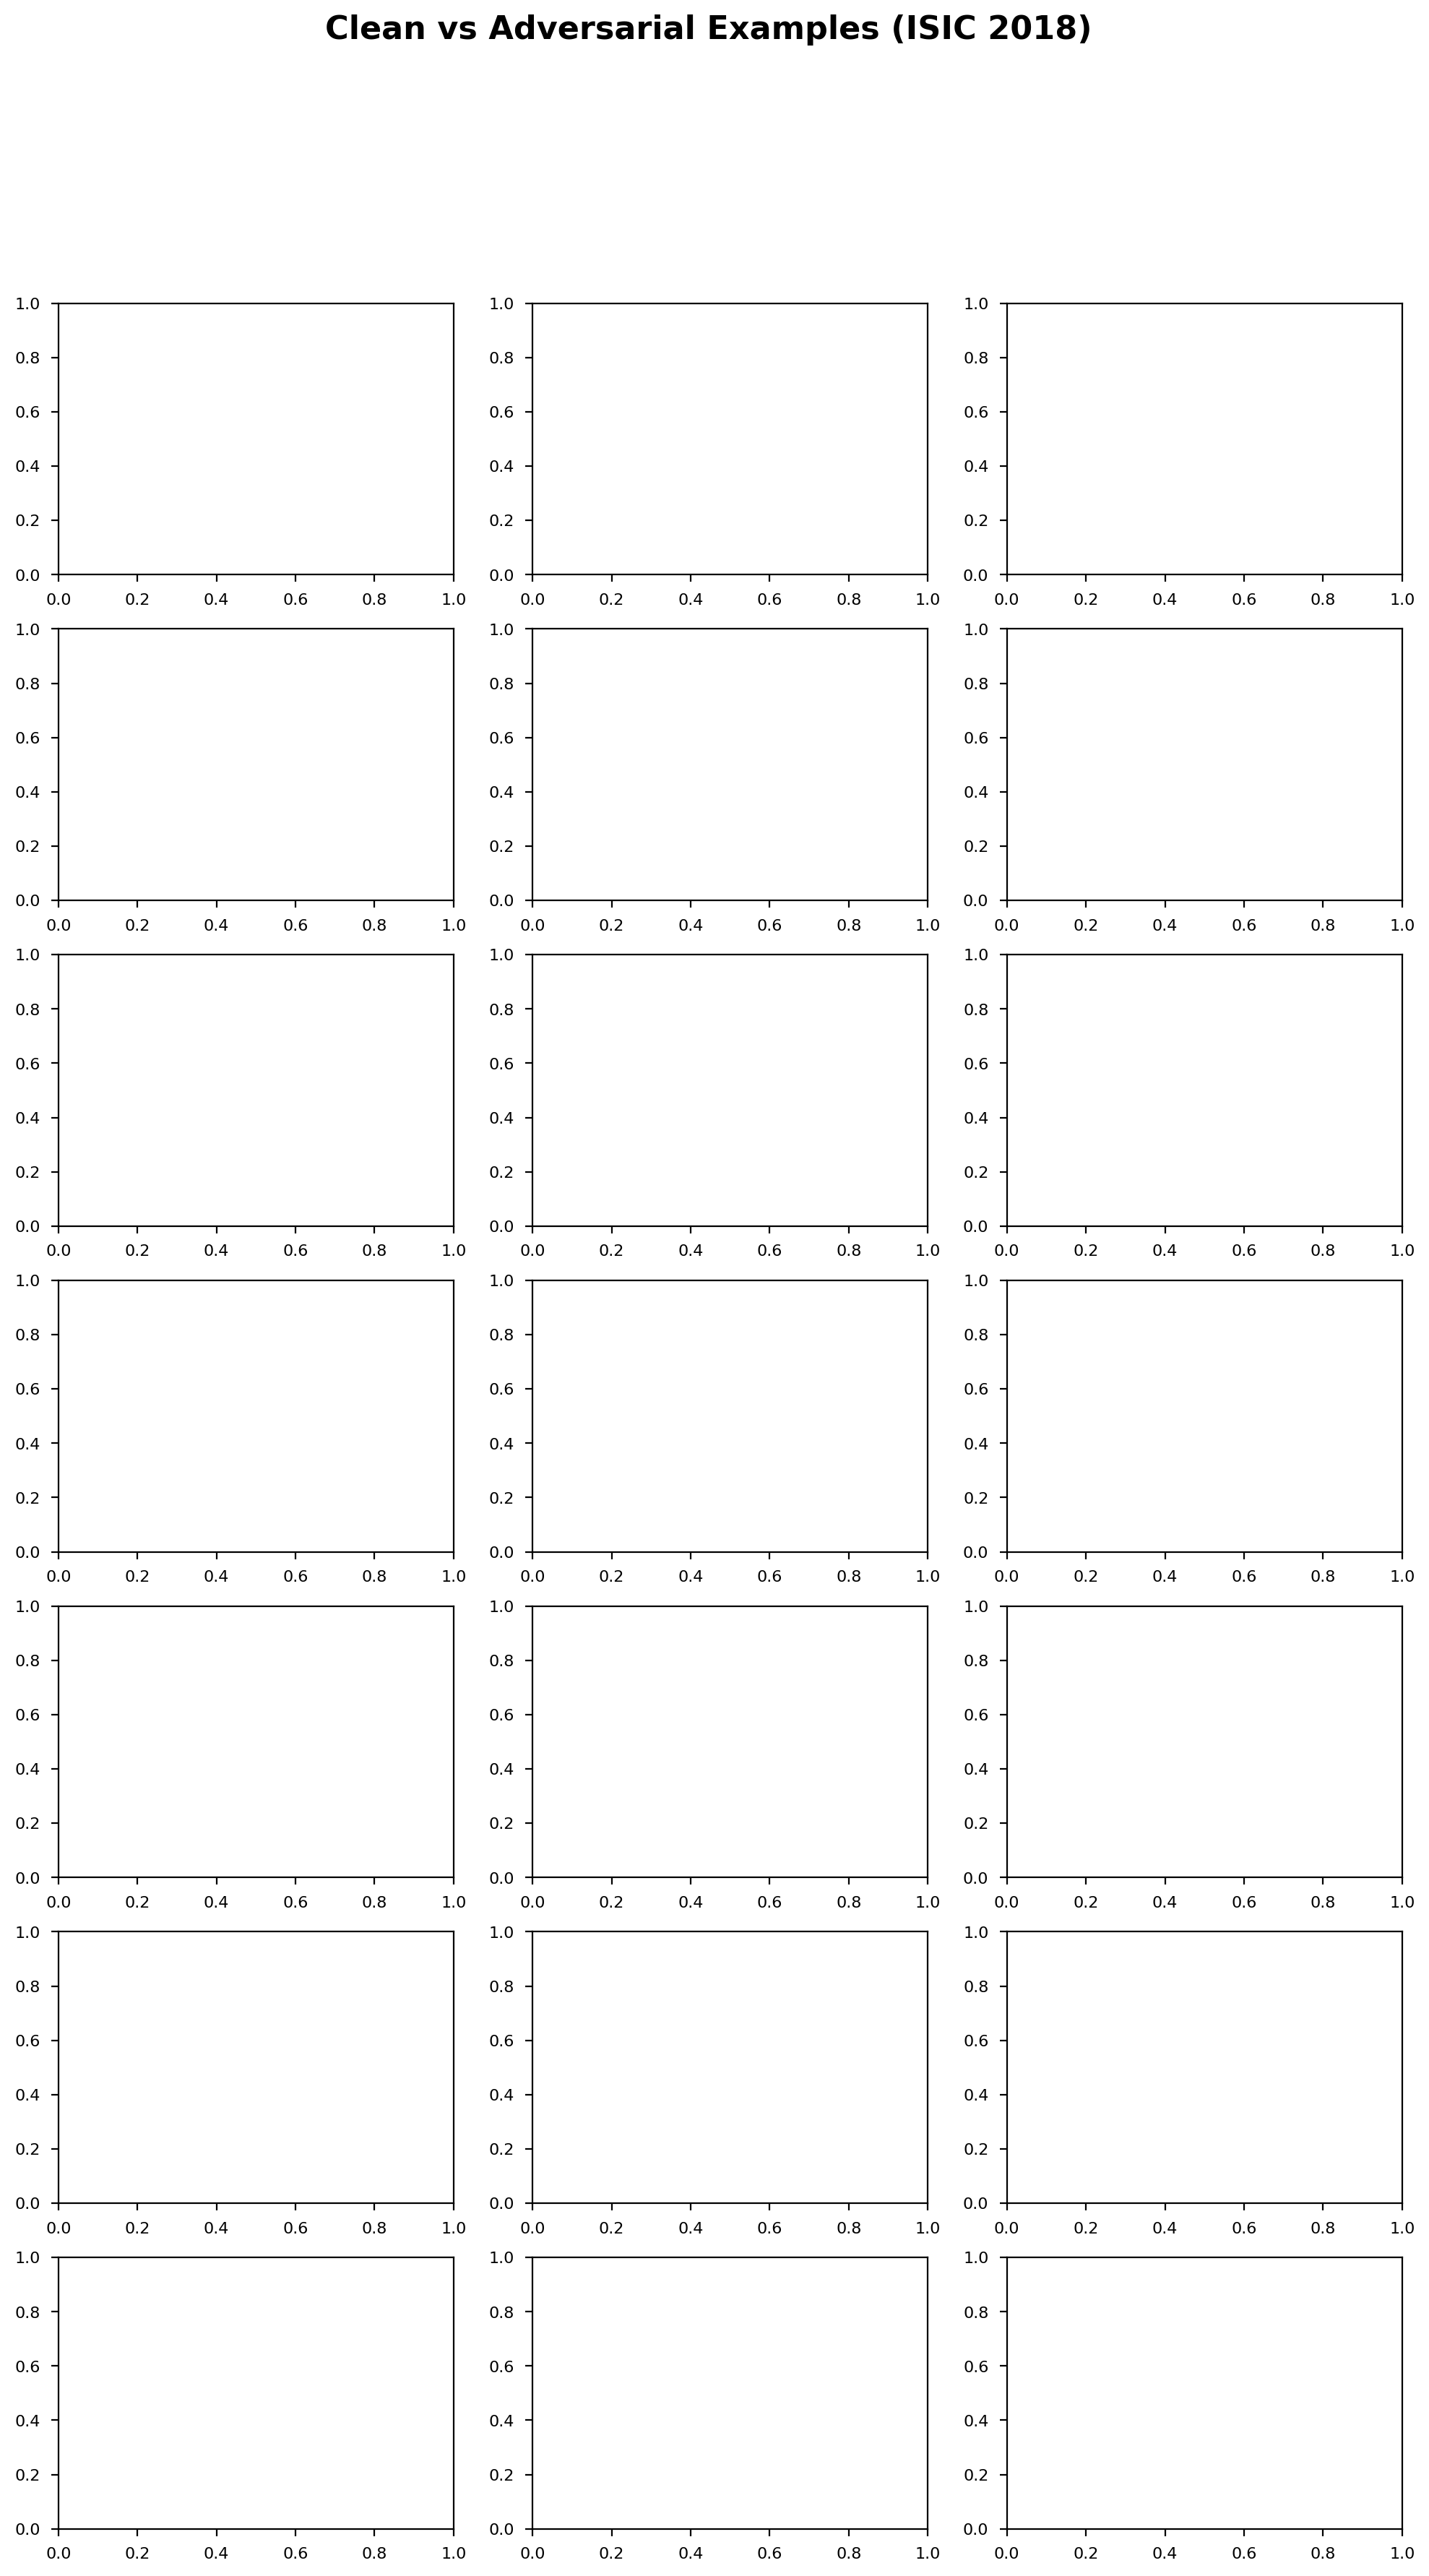

In [3]:
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize ImageNet-normalized tensor."""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return (tensor * std + mean).clamp(0, 1)

fig, axes = plt.subplots(7, 3, figsize=(12, 20))
fig.suptitle("Clean vs Adversarial Examples (ISIC 2018)", fontsize=16, fontweight='bold')

for cls_idx, (cls, advs) in enumerate(all_adversarials.items()):
    # Clean
    clean_img = denormalize(advs["clean"].squeeze(0).cpu())
    axes[cls_idx, 0].imshow(clean_img.permute(1, 2, 0))
    axes[cls_idx, 0].set_title(f"{class_names[cls]}\n(Clean)")
    axes[cls_idx, 0].axis('off')
    
    # FGSM
    fgsm_img = denormalize(advs["fgsm"].squeeze(0).cpu())
    axes[cls_idx, 1].imshow(fgsm_img.permute(1, 2, 0))
    axes[cls_idx, 1].set_title("FGSM (ε=8/255)")
    axes[cls_idx, 1].axis('off')
    
    # PGD
    pgd_img = denormalize(advs["pgd"].squeeze(0).cpu())
    axes[cls_idx, 2].imshow(pgd_img.permute(1, 2, 0))
    axes[cls_idx, 2].set_title("PGD (ε=8/255, 10 steps)")
    axes[cls_idx, 2].axis('off')

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "results" / "figures" / "adversarial_grid.png", dpi=300)
plt.show()

print("✅ Figure 1 saved: adversarial_grid.png")


## SECTION 5: Perturbation Analysis

In [4]:
def compute_perturbation_metrics(clean, adv):
    """Compute perturbation statistics."""
    pert = (adv - clean).abs()
    
    metrics = {
        "l_inf": pert.max().item(),
        "l_2": pert.norm(p=2).item() / np.sqrt(pert.numel()),
        "l_1": pert.norm(p=1).item() / pert.numel(),
        "mean": pert.mean().item(),
        "std": pert.std().item(),
    }
    
    return metrics

# Compute for all attacks
perturbation_stats = {attack: [] for attack in ["fgsm", "pgd"]}

for cls, advs in all_adversarials.items():
    for attack_name in ["fgsm", "pgd"]:
        metrics = compute_perturbation_metrics(advs["clean"], advs[attack_name])
        perturbation_stats[attack_name].append(metrics)

# Visualize perturbation statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Perturbation Magnitude Analysis", fontsize=14, fontweight='bold')

metrics_to_plot = ["l_inf", "l_2", "mean"]
for idx, metric in enumerate(metrics_to_plot):
    data = {
        "FGSM": [s[metric] for s in perturbation_stats["fgsm"]],
        "PGD": [s[metric] for s in perturbation_stats["pgd"]],
    }
    
    axes[idx].bar(data.keys(), [np.mean(v) for v in data.values()])
    axes[idx].set_ylabel(f"{metric.upper()} Norm")
    axes[idx].set_title(f"{metric.upper()} Perturbation")
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "results" / "figures" / "perturbation_analysis.png", dpi=300)
plt.show()

print("✅ Figure 2 saved: perturbation_analysis.png")

NameError: name 'all_adversarials' is not defined

## SECTION 6: Prediction Confidence Analysis

In [5]:
def get_prediction_confidence(model, image, true_label):
    """Get model prediction and confidence."""
    model.eval()
    with torch.no_grad():
        logits = model(image)
        probs = F.softmax(logits, dim=1)
        
        pred_label = logits.argmax(dim=1).item()
        pred_conf = probs[0, pred_label].item()
        true_conf = probs[0, true_label].item()
    
    return {
        "predicted_label": pred_label,
        "predicted_confidence": pred_conf,
        "true_label_confidence": true_conf,
        "correct": pred_label == true_label,
    }

# Analyze confidence for all samples
confidence_analysis = {}
for cls, advs in all_adversarials.items():
    confidence_analysis[cls] = {}
    
    for attack_name, adv_img in advs.items():
        conf = get_prediction_confidence(resnet_model, adv_img, cls)
        confidence_analysis[cls][attack_name] = conf

# Visualize confidence changes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Model Confidence Analysis", fontsize=14, fontweight='bold')

# Plot 1: Confidence on true class
for attack_name in ["clean", "fgsm", "pgd"]:
    confs = [confidence_analysis[cls][attack_name]["true_label_confidence"] 
             for cls in range(7)]
    axes[0].plot(class_names, confs, marker='o', label=attack_name.upper())

axes[0].set_ylabel("Confidence on True Class")
axes[0].set_xlabel("Class")
axes[0].set_title("Confidence Drop Under Attack")
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Attack success rate
success_rates = {}
for attack_name in ["fgsm", "pgd"]:
    successes = [1 - int(confidence_analysis[cls][attack_name]["correct"]) 
                 for cls in range(7)]
    success_rates[attack_name] = np.mean(successes) * 100

axes[1].bar(success_rates.keys(), success_rates.values())
axes[1].set_ylabel("Attack Success Rate (%)")
axes[1].set_title("Overall Attack Success")
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "results" / "figures" / "confidence_analysis.png", dpi=300)
plt.show()

print("✅ Figure 3 saved: confidence_analysis.png")

NameError: name 'all_adversarials' is not defined

## SECTION 7: Summary Statistics

In [6]:
print("\n" + "="*60)
print("ADVERSARIAL EXAMPLES ANALYSIS - SUMMARY")
print("="*60)

print("\nPerturbation Statistics:")
for attack_name in ["fgsm", "pgd"]:
    stats = perturbation_stats[attack_name]
    l_inf_mean = np.mean([s["l_inf"] for s in stats])
    l_2_mean = np.mean([s["l_2"] for s in stats])
    print(f"\n{attack_name.upper()}:")
    print(f"  L∞ norm: {l_inf_mean:.4f}")
    print(f"  L2 norm: {l_2_mean:.4f}")

print("\nAttack Success Rates:")
for attack_name in ["fgsm", "pgd"]:
    successes = [1 - int(confidence_analysis[cls][attack_name]["correct"]) 
                 for cls in range(7)]
    asr = np.mean(successes) * 100
    print(f"  {attack_name.upper()}: {asr:.1f}%")

print("\nConfidence Changes:")
for attack_name in ["clean", "fgsm", "pgd"]:
    confs = [confidence_analysis[cls][attack_name]["true_label_confidence"] 
             for cls in range(7)]
    mean_conf = np.mean(confs) * 100
    print(f"  {attack_name.upper()}: {mean_conf:.1f}%")

print("\n" + "="*60)
print("Analysis complete!")
print("="*60)


ADVERSARIAL EXAMPLES ANALYSIS - SUMMARY

Perturbation Statistics:

FGSM:
  L∞ norm: nan
  L2 norm: nan

PGD:
  L∞ norm: nan
  L2 norm: nan

Attack Success Rates:


c:\Users\Dissertation\tri-objective-robust-xai-medimg\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Dissertation\tri-objective-robust-xai-medimg\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


KeyError: 0